## Network Science Predicts Who Dies Next in Game of Thrones

In this project, we will be predicting which characters are going to die in the following seasons in the GOT. The dataset contains network measures of 94 characters from the first 6 seasons. Different measures of the network can be understod as the social status, importance and connectedness of the characters.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve 
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Loading the dataset
df = pd.read_csv("got_edited.csv", header = 0, sep=';')

### Data Preparation and Feature Engineering

In [4]:
# Check for missing values
df.isna().sum()

id                      0
died                    0
degree                  0
weighted degree         0
pageranks               0
clustering              0
eigencentrality         0
closnesscentrality      0
betweenesscentrality    0
gender                  0
dtype: int64

In [5]:
df

,id,died,degree,weighted degree,pageranks,clustering,eigencentrality,closnesscentrality,betweenesscentrality,gender
0,Joffrey Baratheon,yes,34,73,0.010648,0.567251,0.516207,0.510730,0.005207,male
1,Benjen Stark,yes,23,34,0.007571,0.651515,0.411720,0.508547,0.009492,male
2,Theon Greyjoy,no,43,155,0.013937,0.324111,0.507033,0.548387,0.030976,male
3,Jon Snow Stark,no,74,374,0.024013,0.240216,0.698632,0.595000,0.122631,male
4,Melisandre,no,15,59,0.005920,0.535714,0.106703,0.399329,0.000965,female
...,...,...,...,...,...,...,...,...,...,...
89,Robert Baratheon,yes,21,52,0.006942,0.595238,0.320548,0.515152,0.001687,male
90,Margaery Tyrell,yes,22,58,0.007328,0.727273,0.238246,0.426523,0.000794,female
91,Jojen,yes,11,31,0.005076,1.000000,0.034273,0.358434,0.000000,male
92,Tommen,yes,23,49,0.007694,0.515152,0.240187,0.426523,0.002869,male


As we can see, the dataset is quite small. Only 94 rows and 10 columns. About 50 characters have already died at some point during these 6 seasons, so the ML models can train to predict the next deaths.

In [6]:
# Convert 'gender' column to numerical values
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

# Convert 'died' column to numerical values
df['died'] = df['died'].replace({'yes': 1, 'no': 0})

# Print the updated dataframe
print(df.head())

                  id  died  degree  weighted degree  pageranks  clustering  \
0  Joffrey Baratheon     1      34               73   0.010648    0.567251   
1       Benjen Stark     1      23               34   0.007571    0.651515   
2      Theon Greyjoy     0      43              155   0.013937    0.324111   
3     Jon Snow Stark     0      74              374   0.024013    0.240216   
4         Melisandre     0      15               59   0.005920    0.535714   

   eigencentrality  closnesscentrality  betweenesscentrality  gender  
0         0.516207            0.510730              0.005207       0  
1         0.411720            0.508547              0.009492       0  
2         0.507033            0.548387              0.030976       0  
3         0.698632            0.595000              0.122631       0  
4         0.106703            0.399329              0.000965       1  


In [111]:
#df['gender'] = df['gender'].astype('category')
#df['died'] = df['died'].astype('category')

In [112]:
df.describe()

,died,degree,weighted degree,pageranks,clustering,eigencentrality,closnesscentrality,betweenesscentrality,gender
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.638298,26.265957,69.819149,0.008974,0.591838,0.295524,0.455617,0.013240,0.255319
std,0.483070,19.154817,69.947747,0.005517,0.204082,0.225777,0.063597,0.027552,0.438378
min,0.000000,3.000000,5.000000,0.002947,0.231383,0.008257,0.344928,0.000000,0.000000
25%,0.000000,15.000000,30.250000,0.005610,0.425055,0.148891,0.412122,0.000606,0.000000
50%,1.000000,21.000000,47.000000,0.007028,0.586364,0.233917,0.444861,0.002267,0.000000
75%,1.000000,26.750000,76.750000,0.009593,0.731818,0.343262,0.494303,0.008305,0.750000
max,1.000000,92.000000,374.000000,0.027764,1.000000,1.000000,0.626316,0.127912,1.000000


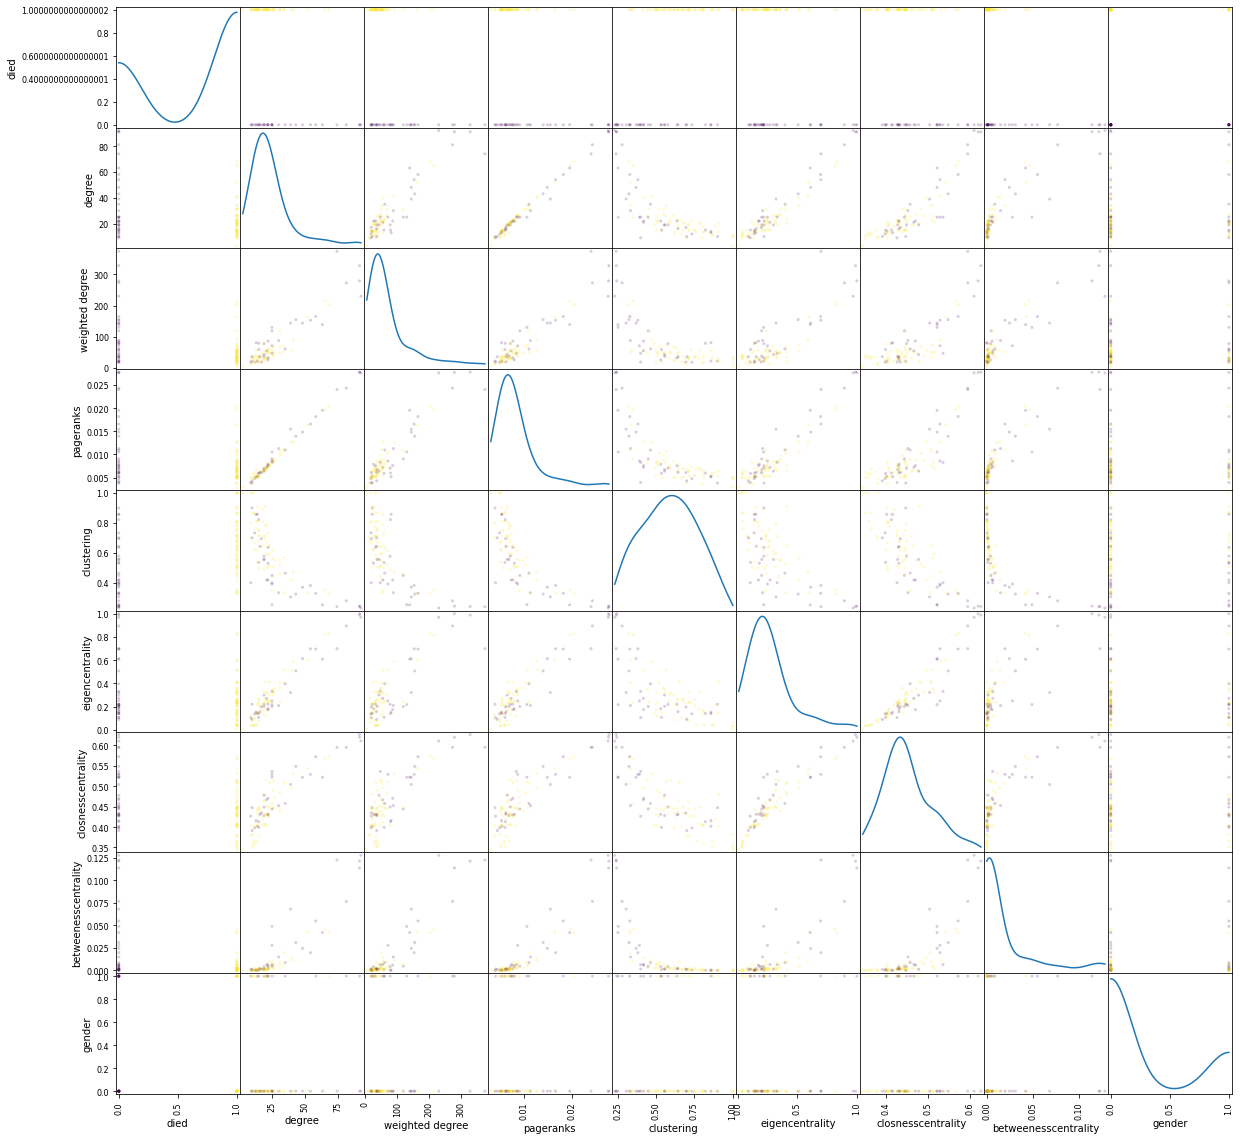

In [157]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha = 0.2, c=y, figsize=(20, 20), diagonal='kde')
plt.show()

<AxesSubplot: >

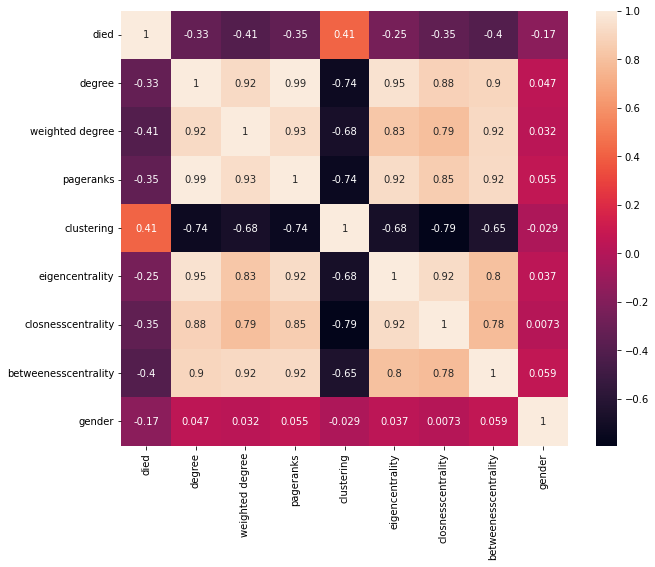

In [162]:
corr = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)

Correlation between various variables are quite high. Because almost all of the variables are network measures calculated based on the node degree, so it is inevitable that they are correlated.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


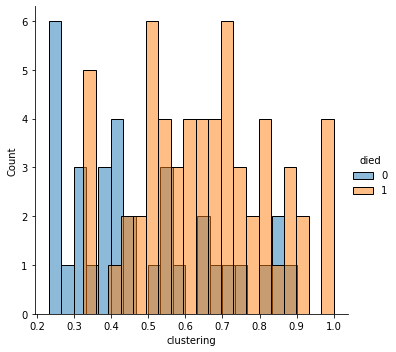

In [158]:
g = sns.FacetGrid(df, hue="died", height=5)
g.map(sns.histplot, "clustering", alpha=.5, bins=20)
g.add_legend()

plt.show()

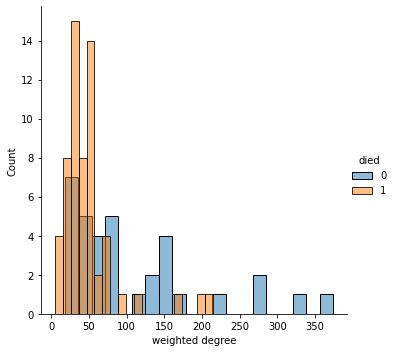

In [161]:
g = sns.FacetGrid(df, hue="died", height=5)
g.map(sns.histplot, "weighted degree", alpha=.5, bins=20)
g.add_legend()

plt.show()

First, I use kfold cross validation technique to determine which classification models perform best on our dataset. Kfold validation is chosen to ensure that the models perform equally well/bad on the entire dataset. If I move on to train and testing technique directly, then some models might be performing well on specific part of the dataset and I might choose worse model by chance.

In [113]:
# Split data into 5 equal groups for validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

I start with 5 models: Logistic Regression, Random Forest, Decision Tree, Support Vector Machines and KNeighbors Classifier.

In [114]:
# Build different models to train on the data

models = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=42), 
          DecisionTreeClassifier(random_state=42), svm.SVC(kernel='rbf', gamma='scale', random_state=42), 
          KNeighborsClassifier()]

In [115]:
# Define target and features
id_col = df['id']
X = df.drop(['id', 'died'], axis=1) # Features
y = df['died'] # Target variable

In [116]:
# Validate each model using K-fold cross validation

mean=[]
std=[]
for model in models:
    result = cross_val_score(model, X, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(result)
    std.append(result)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

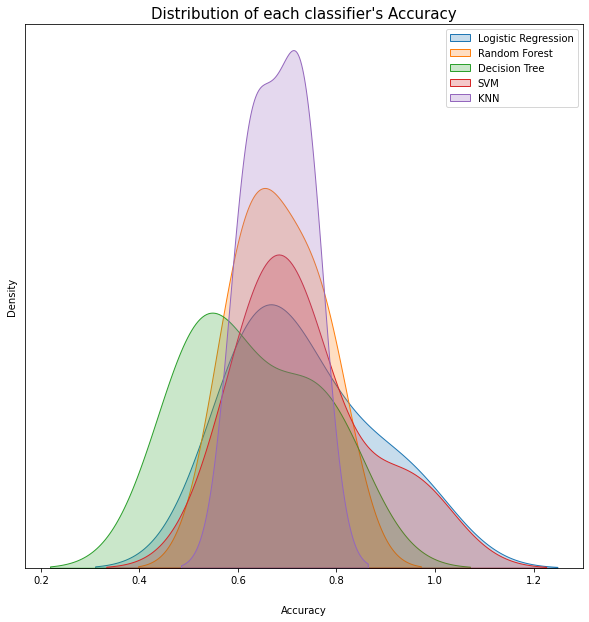

In [117]:
classifiers=['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'KNN']

plt.figure(figsize=(10, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribution of each classifier's Accuracy", fontsize=15)
plt.legend(classifiers)
plt.xlabel("Accuracy", labelpad=20)
plt.yticks([])

plt.show()

As the plot shows, KNN and Random Forest models are performing best. But since the original research used SVM model, I will also employ that one and compare its performance with Random Forest and KNN.

### Tuning the SVM model using GridSearch

In [118]:
c = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel = ['rbf','linear']

hyper_parameters = {'kernel': kernel, 'C': c, 'gamma': gamma}

gs = GridSearchCV(estimator=svm.SVC(), param_grid=hyper_parameters,verbose=True, cv=kfold, n_jobs=-1)

# Find the best hyper-parameters using grid-search (this might take a while)
gs.fit(X,y)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.7444444444444445
SVC(C=0.1, gamma=0.1, kernel='linear')


After tuning the hyperparameters, the accuracy of the model SVM is now 74%, which is similar to the one that the original article suggests.

In [119]:
# Split data keeping 80% for training and the rest for test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=42)

In [172]:
svm_clf = svm.SVC(C=0.1, gamma=0.1, kernel='linear', probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train the classfiers
svm_clf.fit(x_train, y_train)


SVC(C=0.1, gamma=0.1, kernel='linear', probability=True, random_state=42)

In [173]:
rf_clf.fit(x_train, y_train)


RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [174]:
knn_clf.fit(x_train, y_train)

KNeighborsClassifier()

In [175]:
# Get the probability of assigning each sample to either class
svm_prob = svm_clf.predict_proba(x_test)
rf_prob = rf_clf.predict_proba(x_test)
knn_prob = knn_clf.predict_proba(x_test)

# Get the actual predictions
svm_preds = np.argmax(svm_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)
knn_preds = np.argmax(knn_prob, axis=1)

## Performance Comparison

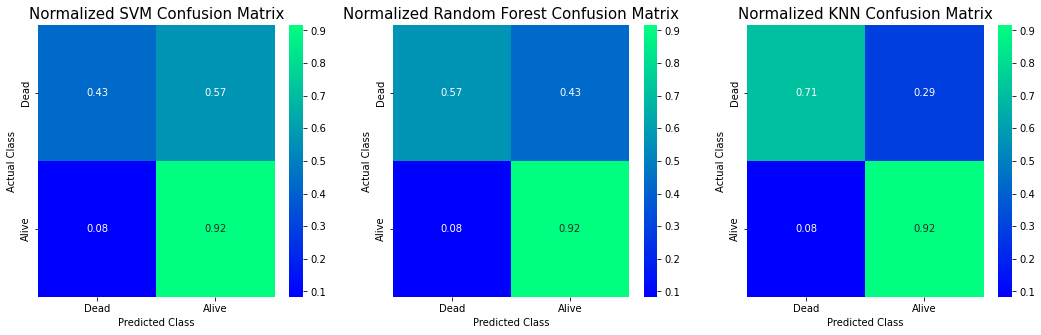

In [176]:
cm = confusion_matrix(y_test, svm_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm2 = confusion_matrix(y_test, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[: , np.newaxis]
cm_knn = confusion_matrix(y_test, knn_preds)
cm_knn = cm_knn.astype('float') / cm_knn.sum(axis=1)[: , np.newaxis]

classes = ["Dead", "Alive"]
f, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].set_title("Normalized SVM Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0]).set(xlabel="Predicted Class", ylabel="Actual Class")

ax[1].set_title("Normalized Random Forest Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
ax[2].set_title("Normalized KNN Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm_knn, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[2]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
plt.show()

All three models are doing equally well at predicting alive characters rather than dead ones. KNN classifier is doing best having 71% of the dead predicted correctly.

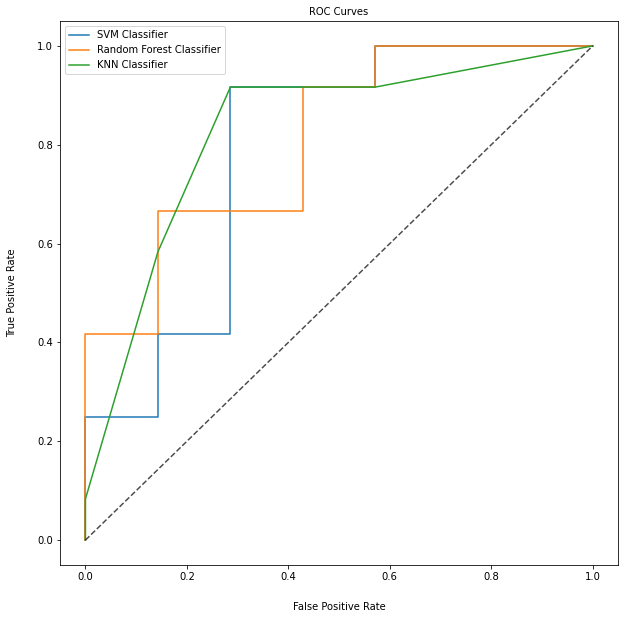

In [177]:
# Plot ROC curves
fig = plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(y_test, svm_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, rf_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, knn_prob[:, 1])[:2])
plt.legend(["SVM Classifier", "Random Forest Classifier", "KNN Classifier"], loc="upper left")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=10)
plt.show()

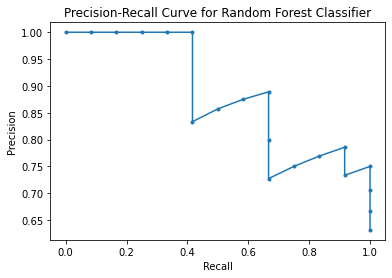

In [178]:
from sklearn.metrics import precision_recall_curve

# Get the precision and recall values for the Random Forest classifier
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_prob[:, 1])

# Plot the precision-recall curve
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest Classifier')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Classifier')

# Show the plot
plt.show()

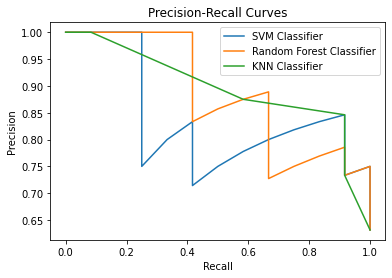

In [179]:
# Get the precision, recall and threshold values for each model
svm_precision, svm_recall, svm_threshold = precision_recall_curve(y_test, svm_prob[:, 1])
rf_precision, rf_recall, rf_threshold = precision_recall_curve(y_test, rf_prob[:, 1])
knn_precision, knn_recall, knn_threshold = precision_recall_curve(y_test, knn_prob[:, 1])

# Plot the precision-recall curves for all models
plt.plot(svm_recall, svm_precision, label="SVM Classifier")
plt.plot(rf_recall, rf_precision, label="Random Forest Classifier")
plt.plot(knn_recall, knn_precision, label="KNN Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [180]:
# So lets take a look at how each model performs on each metric 
print("SVM Classifier Performance")
print("=" * 27)
print(classification_report(y_test, svm_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, svm_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, svm_prob[:, 1])))
print("\n")

print("Random Forest Classifier Performance")
print("=" * 37)
print(classification_report(y_test, rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, rf_prob[:, 1])))
print("\n")

print("KNN Classifier Performance")
print("=" * 27)
print(classification_report(y_test, knn_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, knn_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, knn_prob[:, 1])))
print("\n")

SVM Classifier Performance
              precision    recall  f1-score   support

        Dead       0.75      0.43      0.55         7
       Alive       0.73      0.92      0.81        12

    accuracy                           0.74        19
   macro avg       0.74      0.67      0.68        19
weighted avg       0.74      0.74      0.72        19

Accuracy: 0.74
AUC score: 0.79


Random Forest Classifier Performance
              precision    recall  f1-score   support

        Dead       0.80      0.57      0.67         7
       Alive       0.79      0.92      0.85        12

    accuracy                           0.79        19
   macro avg       0.79      0.74      0.76        19
weighted avg       0.79      0.79      0.78        19

Accuracy: 0.79
AUC score: 0.81


KNN Classifier Performance
              precision    recall  f1-score   support

        Dead       0.83      0.71      0.77         7
       Alive       0.85      0.92      0.88        12

    accuracy             

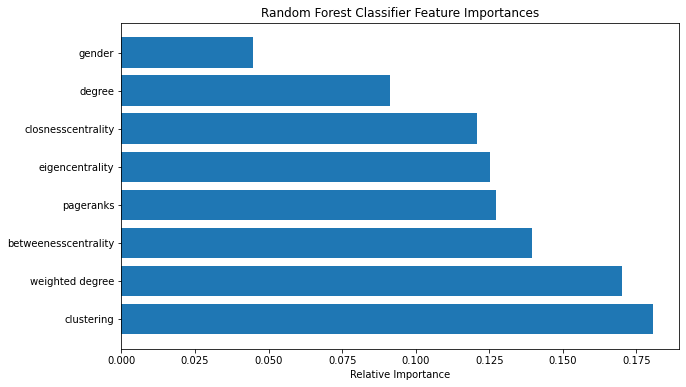

In [183]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Random Forest Classifier Feature Importances', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

Random Forest feature importance diagram shows that gender is the least influential factor at determining a character's death. Whereas clusdtering coefficient and weighted degree are the most important ones.

In [182]:
#Predict the probability of dying for the entire dataset

# SVM model
svm_prob = svm_clf.predict_proba(X)[:, 1]

# Random Forest model
rf_prob = rf_clf.predict_proba(X)[:, 1]

# KNN model
knn_prob = knn_clf.predict_proba(X)[:, 1]


In [155]:
pd.set_option('display.max_rows', None)

In [156]:
# Create a DataFrame to store the results
#results_df = pd.DataFrame(index=y_test['id'], columns=["SVM", "Random Forest", "KNN"])

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=id_col[X.index], columns=["SVM", "Random Forest", "KNN"])

# Fill the DataFrame with the probability of death for each model
results_df["SVM"] = svm_prob
results_df["Random Forest"] = rf_prob
results_df["KNN"] = knn_prob

# Print the results for each model
print("SVM Results:")
print("=" * 13)
print(results_df.sort_values(by=["SVM"], ascending=False)[["SVM"]])
print("\n")

print("Random Forest Results:")
print("=" * 23)
print(results_df.sort_values(by=["Random Forest"], ascending=False)[["Random Forest"]])
print("\n")

print("KNN Results:")
print("=" * 13)
print(results_df.sort_values(by=["KNN"], ascending=False)[["KNN"]])
print("\n")


SVM Results:
                                 SVM
id                                  
Alton Lannister             0.773631
Olyvar                      0.769483
Edmure Tully                0.769481
Khal Moro                   0.765167
Rickard Karstark            0.763047
Black Walder Frey           0.758701
Gendry                      0.755247
Lothar Frey                 0.755023
Syrio Forel                 0.754534
Maryn Trant                 0.752401
Roose Bolton                0.751968
Areo                        0.751323
Benjen Stark                0.749416
Blackfish Tully             0.747782
Lancel Lannister            0.745952
Yoren                       0.743027
Walder Frey                 0.741521
Ros                         0.741401
Robin Arryn                 0.741190
Trystane Martell            0.738806
Three-Eyedd Raven           0.734507
Loras Tyrell                0.732287
Janos Slynt                 0.732279
Doran Martell               0.732067
Mace Tyrell              

Finally, I ran the models on the entire dataset to get the predictions for the future seasons. All three models predict that Daenerys and John Snow will survive. This could be considered as an accurate prediction if we ignore that John died and resurrected, whereas Daenerys lived till the last episode of the series.<br/>
However, there are obvious missclasifications like Robb Stark and Brandon Stark that KNN predicts reverse destinies for them.Whereas SVM model mispredicts the fortune of Ned Stark, predicting only 30% probability that he will die.

In general, considering the small size of the dataset and the fact that the models are using only network measurements of the characters, all three classifiers are doing amazing job.